In [60]:
%matplotlib notebook
import matplotlib.pyplot as plt

from datetime import datetime

from lib import utils
from lib.config import Config
from lib.models.bundle import Bundle
from lib.models.notification import Notification

In [39]:
notifications_filepath = "../data/notifications.csv"
bundles_filepath = "../data/bundles.csv"

In [40]:
notifications = list()
with open(notifications_filepath, "r") as fp:
    for line in fp.readlines():
        notifications.append(Notification.from_line(line, Config.CSV_HEADERS, ','))
        
span_notifications = notifications[-1].timestamp - notifications[0].timestamp
span_notifications_seconds = span.total_seconds()

In [88]:
# get all bundles and users with number of bundles sent per user
users = dict()
bundles = list()

timestamp_first_bundle = datetime(2030, 1, 1)
timestamp_last_bundle = datetime(1800, 1, 1)

with open(bundles_filepath, "r") as fp:
    for line in fp.readlines():
        split = utils.split_csv_line(line, ',')
        
        bundle = Bundle(split[2], datetime.strptime(split[0], Bundle._TIMESTAMP_FORMAT), 
                        datetime.strptime(split[1], Bundle._TIMESTAMP_FORMAT), split[3], "UNKNOWN", "UNKOWN")
        bundles.append(bundle)
        
        if bundle.receiver_id not in users:
            users[bundle.receiver_id] = 1
        else:
            users[bundle.receiver_id] += 1
                                
span_bundles = bundles[-1].timestamp_last_tour - bundles[0].timestamp_last_tour
span_bundles_seconds = span.total_seconds()

# converting values for users to daily averages
for uid, val in users.items():
    users[uid] = val / (span_bundles_seconds / 3600 / 24)

In [89]:
print(f"Number of users: {len(users)}")
print(f"Number of notifications: {len(notifications)}")
print(f"Number of bundles: {len(bundles)}")
print(f"Sample time span: {span_bundles}")

Number of users: 14094
Number of notifications: 337657
Number of bundles: 337657
Sample time span: 61 days, 1:26:25


In [90]:
avg_daily_bundles = len(bundles) / len(users) / (span_bundles_seconds / 3600 / 24)
avg_compression = 1 - len(bundles) / len(notifications)
avg_delay = sum([(b.timestamp_last_tour - b.timestamp_first_tour).total_seconds() for b in bundles]) / len(bundles)

In [91]:
print(f"Average delay: {avg_delay:.2f}s")
print(f"Average compression: {avg_compression * 100:.2f}%")
print(f"Average daily bundles per user: {avg_daily_bundles:.4f} bundle / user / day")

Average delay: 0.00s
Average compression: 0.00%
Average daily bundles per user: 0.3924 bundle / user / day


## Focusing on the top notified users

As gone over in the `notifications.ipynb` notebook we focus on the top notified users defined as receiving on average more than 4 notifications / bundles a day.

In [106]:
top_users_daily = {uid: val for uid, val in users.items() if val > 4}
rest_users_daily = {uid: val for uid, val in users.items() if val <= 4}

In [107]:
print(f"Number of top notified users: {len(top_users_daily)}")
print(f"Proportionally: {len(top_users_daily) / len(users) * 100:.2f}% of the userbase")

Number of top notified users: 129
Proportionally: 0.92% of the userbase


<IPython.core.display.Javascript object>


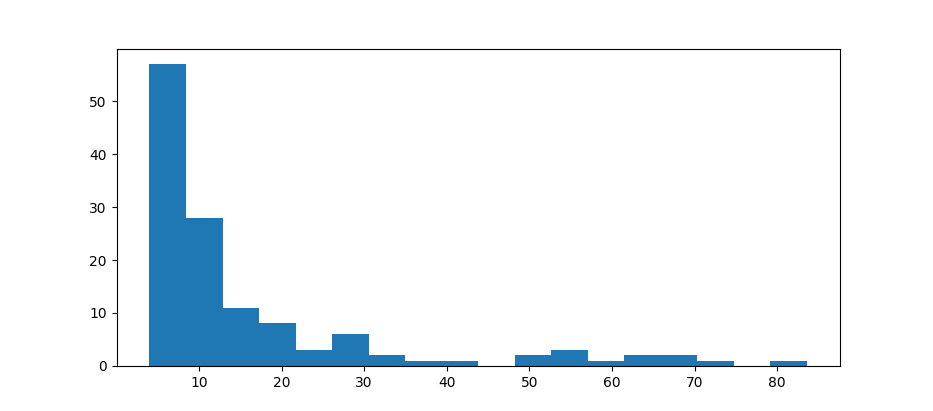

In [98]:
# histogram of daily number of bundles sent to top notified users
plt.hist(sorted(list(top_users_daily.values())), bins='auto')
plt.show()

In [112]:
impact_bombardment_rest = sum(rest_users_daily.values()) / len(rest_users_daily)  # previously defined as: avg_daily_bundles
impact_bombardment_top = sum(top_users_daily.values()) / len(top_users_daily)

rest_bundles = [b for b in bundles if b.receiver_id in rest_users_daily]
top_bundles = [b for b in bundles if b.receiver_id in top_users_daily]

impact_delay_rest = sum(
    [
        (b.timestamp_last_tour - b.timestamp_first_tour).total_seconds() 
        for b in rest_bundles
    ]) / len(rest_bundles)

impact_delay_top = sum(
    [
        (b.timestamp_last_tour - b.timestamp_first_tour).total_seconds() 
        for b in top_bundles
    ]) / len(top_bundles)

In [115]:
print(f"Bombardment as the daily average number of bundles for rest of users: {impact_bombardment_all:.4f} bundle/day/rest_user")
print(f"Bombardment as the daily average number of bundles for top users: {impact_bombardment_top:.4f} bundle/day/top_user\n")

print(f"Averaged bunle delay for rest of users: {impact_delay_rest:.2f} seconds")
print(f"Averaged bunle delay for top users: {impact_delay_top:.2f} seconds")

Bombardment as the daily average number of bundles for rest of users: 0.3924 bundle/day/rest_user
Bombardment as the daily average number of bundles for top users: 16.0404 bundle/day/top_user

Averaged bunle delay for rest of users: 0.00 seconds
Averaged bunle delay for top users: 0.00 seconds
